Load some libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

Define datasets

In [2]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Try to use GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Images in the dataset look like

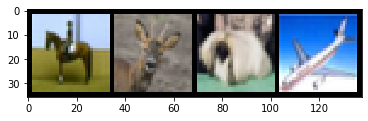

horse deer dog plane


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img: torch.Tensor) -> None:
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join((classes[labels[j]] for j in range(4))))

Define a neural network

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Load net

In [17]:
PATH = './cifar_net_50%.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Use gradient descent for learning

In [24]:
import torch.optim as optim

net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

In [ ]:
for data_iter in range(5):
    average_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        average_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] average loss: %.3f' %
                  (data_iter + 1, i + 1, average_loss / 2000))
            average_loss = 0.0

print('Complete')

[1,  2000] average loss: 0.865
[1,  4000] average loss: 0.866
[1,  6000] average loss: 0.860
[1,  8000] average loss: 0.859
[1, 10000] average loss: 0.873
[1, 12000] average loss: 0.869
[2,  2000] average loss: 0.861
[2,  4000] average loss: 0.865
[2,  6000] average loss: 0.850
[2,  8000] average loss: 0.874
[2, 10000] average loss: 0.868
[2, 12000] average loss: 0.868
[3,  2000] average loss: 0.869
[3,  4000] average loss: 0.865
[3,  6000] average loss: 0.843
[3,  8000] average loss: 0.862
[3, 10000] average loss: 0.860
[3, 12000] average loss: 0.871
[4,  2000] average loss: 0.882
[4,  4000] average loss: 0.847
[4,  6000] average loss: 0.846
[4,  8000] average loss: 0.856
[4, 10000] average loss: 0.863


Let's test our NN

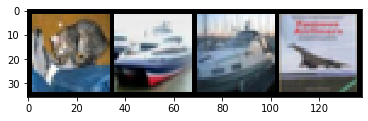

Actual labels: cat ship ship plane


In [47]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("Actual labels:", ' '.join((classes[labels[j]] for j in range(4))))

In [48]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   cat  ship plane plane


In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy on the 10000 test images: 55 %


Save our beautiful model for future generations

In [12]:
PATH = './cifar_net_50%.pth'
torch.save(net.state_dict(), PATH)